In [2]:
import numpy as np
import pandas as pd
import json
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from src.constants import Column
from helper_fun import remove_highly_correlated_features
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import mplscience

# ensures notebook gets updated immediately when src files change
%load_ext autoreload
%autoreload 2

mplscience.available_styles()
mplscience.set_style(reset_current=True)

['default', 'despine']


In [2]:
cp_selected_gene = pd.read_pickle('/home/wangz222/scratch/embedding/cellprofiler/singlecell_select_gene.pkl')

#filter out some genes not related to actin cytoskeleton and adhesion 
genes_not_involved = ['KPNB1', 'NUP88', 'COP1', 'SEC61G', 'SEC61A1', 'CSE1L', 'RBM8A',
                       'MCRS1','KAT8','SRRT','TLK2','NUP214', 'SFPQ', 'NUTF2', 'RANBP2',
                        'RANGAP1','DDX3X','XPO1', 'NCBP1', 'NCBP2', 'KANSL1', 'KANSL2', 'KANSL3']
cp_selected_gene = cp_selected_gene[~cp_selected_gene['gene_symbol_0'].isin(genes_not_involved)]

# multiple hypothesis testing
with open('/home/wangz222/data/KEGG_modified_cluster.json', 'r') as file:
    gene_function = json.load(file)
cp_selected_gene['function'] = cp_selected_gene[Column.gene.value].map(gene_function)
cp_selected_gene['batch'] = cp_selected_gene['plate']+cp_selected_gene['well']

In [3]:
xls = pd.ExcelFile('/home/wangz222/cellprofiler/extracted_image_features.xlsx')
image_features = xls.parse('(B) Extracted image features', header=1)['feature']

In [4]:
ntc = cp_selected_gene[(cp_selected_gene[Column.gene.value] == 'nontargeting')][image_features]
corr_mat = np.corrcoef(np.transpose(ntc))
# Call the function with the correlation matrix and a threshold
features_to_keep = remove_highly_correlated_features(corr_mat, threshold=0.9)
# Select only the features that are not highly correlated
ntc = ntc.iloc[:, features_to_keep]
# Remove DNA damage channel features as those are likely different for any perturbation compared to ntc
features_to_keep = [name for name in ntc.columns if 'gh2ax' not in name]

In [105]:
batch = '20200202_6W-LaC024AB2'
select_batch = cp_selected_gene['batch'] == batch
ntc_batch = cp_selected_gene[cp_selected_gene[Column.gene.value] == 'nontargeting']['batch'] == batch
tubulin_feat = np.arcsinh(cp_selected_gene[(cp_selected_gene['function']=='Tubulin') & select_batch][['cell_tubulin_haralick_5_10', 'cell_lstsq_slope_tubulin_dapi']])
actin_feat = np.arcsinh(cp_selected_gene[(cp_selected_gene['function']=='Actin cytoskeleton & Adhesion') & select_batch][['cell_tubulin_haralick_5_10', 'cell_lstsq_slope_tubulin_dapi']])
ntc_feat = np.arcsinh(ntc[ntc_batch][['cell_tubulin_haralick_5_10', 'cell_lstsq_slope_tubulin_dapi']])
print(batch)
print(ntc_feat.std()[['cell_lstsq_slope_tubulin_dapi', 'cell_tubulin_haralick_5_10']])

20200202_6W-LaC024AB2
cell_lstsq_slope_tubulin_dapi    0.825003
cell_tubulin_haralick_5_10       0.888985
dtype: float64


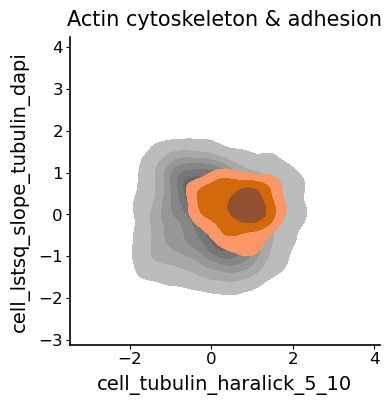

/home/wangz222/miniconda3/envs/ops/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
/home/wangz222/miniconda3/envs/ops/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


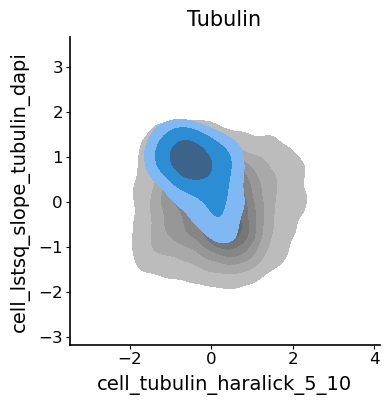

In [106]:
sns.kdeplot(x='cell_tubulin_haralick_5_10', y='cell_lstsq_slope_tubulin_dapi', data=ntc_feat, color='grey', fill=True, levels=8)
sns.kdeplot(x='cell_tubulin_haralick_5_10', y='cell_lstsq_slope_tubulin_dapi', data=actin_feat, fill=True, color='tab:orange', levels=[0.5, 0.7, 0.9, 1])
plt.title('Actin cytoskeleton & adhesion')
plt.show()

sns.kdeplot(x='cell_tubulin_haralick_5_10', y='cell_lstsq_slope_tubulin_dapi', data=ntc_feat, s=5, color='grey', fill=True, levels=8)
sns.kdeplot(x='cell_tubulin_haralick_5_10', y='cell_lstsq_slope_tubulin_dapi', data=tubulin_feat, s=5, color='tab:blue', fill=True, levels=[0.5, 0.7, 0.9, 1])
plt.title('Tubulin')
plt.show()

In [33]:
batch_list = cp_selected_gene['batch'].unique()
top_k = 20
tubulin_top_features = pd.DataFrame(index=batch_list, columns=range(top_k))
actin_top_features = pd.DataFrame(index=batch_list, columns=range(top_k))
for batch in batch_list[0:1]:
    print(batch)
    select = cp_selected_gene['batch'] == batch

    ntc = cp_selected_gene[(cp_selected_gene[Column.gene.value] == 'nontargeting')&select][features_to_keep]
    actin_adhesion = cp_selected_gene[(cp_selected_gene['function'] == 'Actin cytoskeleton & Adhesion')&select][features_to_keep]
    tubulin = cp_selected_gene[(cp_selected_gene['function'] == 'Tubulin')&select][features_to_keep]
    # Perform t-tests for corresponding columns and store results
    results = []
    for col in ntc.columns:
        t_stat, p_val = stats.ttest_ind(ntc[col], actin_adhesion[col], equal_var=False)
        robust_z = (np.median(actin_adhesion[col]) - np.median(ntc[col]))/stats.median_abs_deviation(ntc[col])
        results.append((col, t_stat, p_val, robust_z))

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results, columns=['Column', 'T-Stat', 'P-Value', 'robust z-score'])

    # Apply Bonferroni correction
    corrected_p_values = multipletests(results_df['P-Value'], method='bonferroni')
    results_df['Adjusted P-Value'] = corrected_p_values[1]
    # Calculate -log10 of the p-values
    results_df['-Log10(P-Value)'] = -np.log10(results_df['Adjusted P-Value']+1e-16)

    results_df_actin = results_df.copy()
    results_df_actin['robust z-score'] = results_df_actin['robust z-score']
    results_df_actin.sort_values(by='robust z-score', ascending=False, inplace=True)

    # Perform t-tests for corresponding columns and store results
    results = []
    for col in ntc.columns:
        t_stat, p_val = stats.ttest_ind(ntc[col], tubulin[col], equal_var=False)
        robust_z = (np.median(tubulin[col]) - np.median(ntc[col]))/stats.median_abs_deviation(ntc[col])
        results.append((col, t_stat, p_val, robust_z))

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results, columns=['Column', 'T-Stat', 'P-Value', 'robust z-score'])

    # Apply Bonferroni correction
    corrected_p_values = multipletests(results_df['P-Value'], method='bonferroni')
    results_df['Adjusted P-Value'] = corrected_p_values[1]
    # Calculate -log10 of the p-values
    results_df['-Log10(P-Value)'] = -np.log10(results_df['Adjusted P-Value']+1e-16)

    results_df_tubulin = results_df.copy()
    results_df_tubulin['robust z-score'] = results_df_tubulin['robust z-score']
    results_df_tubulin.sort_values(by='robust z-score', ascending=False, inplace=True)

    tubulin_top_features.loc[batch] = list(results_df_tubulin['Column'][:top_k])
    actin_top_features.loc[batch] = list(results_df_actin['Column'][:top_k])

    common_elements = set(tubulin_top_features.loc[batch]).intersection(actin_top_features.loc[batch])
    number_of_common_elements = len(common_elements)

    print(number_of_common_elements)

20200206_6W-LaC025AB1


/tmp/ipykernel_3111097/3971131677.py:16: RuntimeWarning: invalid value encountered in scalar divide
  robust_z = (np.median(actin_adhesion[col]) - np.median(ntc[col]))/stats.median_abs_deviation(ntc[col])
/tmp/ipykernel_3111097/3971131677.py:36: RuntimeWarning: invalid value encountered in scalar divide
  robust_z = (np.median(tubulin[col]) - np.median(ntc[col]))/stats.median_abs_deviation(ntc[col])
/tmp/ipykernel_3111097/3971131677.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  robust_z = (np.median(tubulin[col]) - np.median(ntc[col]))/stats.median_abs_deviation(ntc[col])


0


### linear regression of the top differential features to predict first pcs of NTCs

In [8]:
df_ntc = cp_selected_gene[(cp_selected_gene[Column.gene.value] == 'nontargeting')]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_ntc[features_to_keep])

# Perform PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(scaled_features)
pc_df = pd.DataFrame(data = principalComponents, columns = [f'PC{ii}' for ii in range(1, 1+principalComponents.shape[1])])

print('Explained variation by principal components: {}'.format(pca.explained_variance_ratio_))

Explained variation by principal components: [0.13411179 0.08709625 0.05840443]


In [9]:
# Define a function to get the mode and its count for a Series
def mode_and_count(series):
    mode = series.mode().iloc[0]
    count = series.value_counts().loc[mode]
    return mode, count

# Apply the function to each column
for column in tubulin_top_features.columns:
    mode, count = mode_and_count(tubulin_top_features[column])
    print(f"Column {column}: Mode = {mode}, Count = {count}")

Column 0: Mode = cell_lstsq_slope_tubulin_dapi, Count = 14
Column 1: Mode = cell_lstsq_slope_tubulin_dapi, Count = 23
Column 2: Mode = nucleus_lstsq_slope_dapi_tubulin, Count = 15
Column 3: Mode = nucleus_lstsq_slope_dapi_tubulin, Count = 12
Column 4: Mode = cell_K_tubulin_dapi, Count = 5
Column 5: Mode = cell_tubulin_haralick_5_9, Count = 5
Column 6: Mode = nucleus_rwc_phalloidin_tubulin, Count = 7
Column 7: Mode = cell_tubulin_haralick_5_9, Count = 6
Column 8: Mode = nucleus_tubulin_mean_frac_2, Count = 5
Column 9: Mode = nucleus_correlation_dapi_tubulin, Count = 6
Column 10: Mode = nucleus_tubulin_mean_frac_1, Count = 6
Column 11: Mode = nucleus_tubulin_mean_frac_1, Count = 5
Column 12: Mode = cell_tubulin_haralick_5_4, Count = 3
Column 13: Mode = cell_correlation_dapi_tubulin, Count = 4
Column 14: Mode = nucleus_tubulin_mean_frac_1, Count = 3
Column 15: Mode = cell_tubulin_haralick_5_4, Count = 4
Column 16: Mode = cell_correlation_dapi_tubulin, Count = 3
Column 17: Mode = cell_tubu

In [10]:
tubulin_feat = ['cell_lstsq_slope_tubulin_dapi','nucleus_lstsq_slope_dapi_tubulin',
'cell_K_tubulin_phalloidin','nucleus_tubulin_mean_frac_2','cell_K_tubulin_dapi',
'nucleus_tubulin_pftas_17','nucleus_tubulin_pftas_26','nucleus_rwc_phalloidin_tubulin',
'nucleus_tubulin_mean_frac_1','cell_tubulin_haralick_5_9','nucleus_tubulin_mean_frac_2',
'nucleus_rwc_phalloidin_tubulin', 'nucleus_correlation_dapi_tubulin','nucleus_tubulin_mean_frac_1',
'cell_correlation_dapi_tubulin']

In [11]:
counts = tubulin_top_features.iloc[:,:4].values.flatten()
counts_series = pd.Series(counts).value_counts()
tubulin_dict = counts_series.to_dict()

counts = actin_top_features.iloc[:,:4].values.flatten()
counts_series = pd.Series(counts).value_counts()
actin_dict = counts_series.to_dict()

In [26]:
actin_dict

{'cell_tubulin_haralick_5_10': 33,
 'cell_phalloidin_mad': 23,
 'cell_tubulin_haralick_5_1': 22,
 'cell_tubulin_mad': 20,
 'cell_phalloidin_haralick_5_5': 19,
 'nucleus_phalloidin_haralick_5_5': 14,
 'cell_tubulin_std': 14,
 'nucleus_tubulin_upper_quartile': 8,
 'nucleus_tubulin_mean': 5,
 'cell_tubulin_haralick_5_8': 4,
 'cell_phalloidin_std': 4,
 'nucleus_tubulin_haralick_5_5': 3,
 'nucleus_tubulin_median': 3,
 'nucleus_tubulin_mean_edge': 2,
 'cell_phalloidin_haralick_5_8': 2,
 'nucleus_phalloidin_haralick_5_12': 2,
 'nucleus_phalloidin_haralick_5_2': 2,
 'cell_phalloidin_haralick_5_10': 2,
 'nucleus_tubulin_mad': 1,
 'cell_phalloidin_haralick_5_7': 1}

In [25]:
tubulin_dict

{'cell_lstsq_slope_tubulin_dapi': 43,
 'nucleus_lstsq_slope_dapi_tubulin': 31,
 'cell_K_tubulin_phalloidin': 23,
 'nucleus_tubulin_mean_frac_2': 15,
 'cell_K_tubulin_dapi': 13,
 'nucleus_tubulin_pftas_17': 12,
 'nucleus_tubulin_pftas_26': 10,
 'nucleus_tubulin_mean_frac_1': 5,
 'cell_tubulin_haralick_5_9': 4,
 'cell_tubulin_weighted_hu_moments_0': 3,
 'nucleus_rwc_phalloidin_tubulin': 3,
 'nucleus_tubulin_pftas_20': 2,
 'cell_tubulin_haralick_5_0': 2,
 'nucleus_tubulin_pftas_6': 2,
 'nucleus_manders_dapi_tubulin': 2,
 'cell_correlation_dapi_tubulin': 2,
 'nucleus_K_tubulin_phalloidin': 2,
 'nucleus_manders_phalloidin_tubulin': 1,
 'nucleus_dapi_min_edge': 1,
 'nucleus_tubulin_pftas_2': 1,
 'cell_tubulin_pftas_6': 1,
 'nucleus_tubulin_haralick_5_9': 1,
 'nucleus_tubulin_pftas_19': 1,
 'cell_tubulin_pftas_24': 1,
 'nucleus_tubulin_pftas_5': 1,
 'nucleus_tubulin_pftas_3': 1,
 'nucleus_tubulin_pftas_7': 1}

### make volcano plot

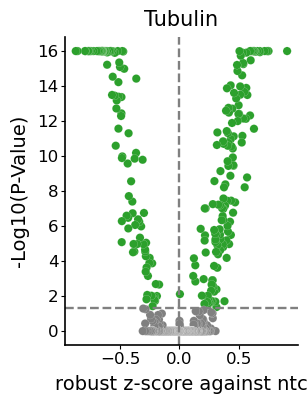

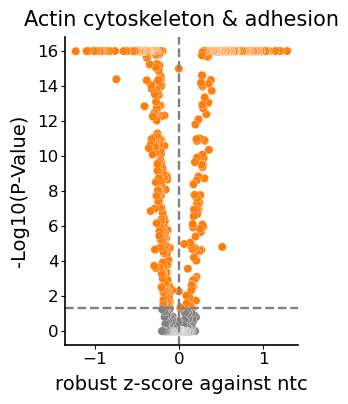

In [35]:
# Define the threshold
threshold = -np.log10(0.05)

# Create a color map based on the threshold
results_df_tubulin['color'] = np.where(results_df_tubulin['-Log10(P-Value)'] > threshold, 'tab:green', 'gray')

plt.figure(figsize=(3, 4))
sns.scatterplot(data=results_df_tubulin, x='robust z-score', y='-Log10(P-Value)',
                hue='color', palette=['tab:green', 'gray'], legend=False, linewidth=0.1)
plt.axhline(y=threshold, color='gray', linestyle='--') # Threshold line for p-value
plt.axvline(x=0, color='gray', linestyle='--') # Threshold line for robust z-score
plt.title('Tubulin')
plt.xlabel('robust z-score against ntc')
plt.ylabel('-Log10(P-Value)')
plt.savefig('figure/figure_3/tubulin_volcano_plot.svg')
plt.show()

plt.figure(figsize=(3, 4))
results_df_actin['color'] = np.where(results_df_actin['-Log10(P-Value)'] > threshold, 'tab:orange', 'gray')

sns.scatterplot(data=results_df_actin, x='robust z-score', y='-Log10(P-Value)',
                hue='color', palette=['tab:orange', 'gray'], legend=False, linewidth=0.2)
plt.axhline(y=threshold, color='gray', linestyle='--') # Threshold line for p-value
plt.axvline(x=0, color='gray', linestyle='--') # Threshold line for robust z-score
plt.title('Actin cytoskeleton & adhesion')
plt.xlabel('robust z-score against ntc')
plt.ylabel('-Log10(P-Value)')
plt.savefig('figure/figure_3/actin_volcano_plot.svg')
plt.show()

In [ ]:
result_dict = {}
gene_list = {'tubulin': list(tubulin_dict.keys()), 'actin cytoskeleton & adhesion': list(actin_dict.keys())}
for key, value in gene_list.items():
    final_dfs = []
    for ii in np.arange(1, 16, 1):
        print(ii)
        result_dfs = []
        df_predictors = df_ntc[gene_list[key][:ii]]
        for column in pc_df.columns[0:1]:
            # Extract the response variable for this iteration
            y = pc_df[column]
            
            # Initialize and fit the linear regression model
            model = LinearRegression()
            model.fit(df_predictors, y)
            y_pred = model.predict(df_predictors)

            # Calculate the variance explained (R-squared)
            r2 = r2_score(y, y_pred)

            # Calculate the mean absolute error (MAE)
            mae = abs(y - y_pred).mean()

            # Append to results DataFrame
            iter_result_df = pd.DataFrame({
                'Response Variable': [column],
                'Mean Absolute Error': [mae],
                'Variance Explained': [r2]
            })
            result_dfs.append(iter_result_df)
        results_df_x = pd.concat(result_dfs, ignore_index=True)
        iter_final_result = pd.DataFrame({
                'Top k differential features': [ii],
                'Mean Absolute Error': np.mean(results_df_x['Mean Absolute Error']),
                'Variance Explained': np.mean(results_df_x['Variance Explained'])
            })
        final_dfs.append(iter_final_result)
    result_dict[key] = pd.concat(final_dfs, ignore_index=True)

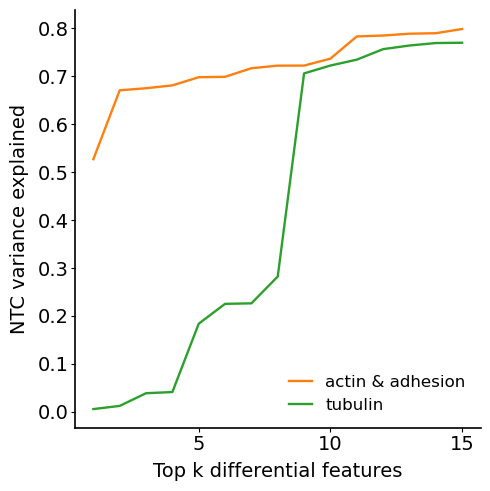

In [24]:
plt.figure(figsize=(5, 5))
# Create the line plot
sns.lineplot(x='Top k differential features', y='Variance Explained', data=result_dict['actin cytoskeleton & adhesion'], errorbar=None, 
                label='actin & adhesion', color='tab:orange')
sns.lineplot(x='Top k differential features', y='Variance Explained', data=result_dict['tubulin'], errorbar=None, 
                label='tubulin', color='tab:green')
plt.ylabel('NTC variance explained')
plt.legend(loc='lower right')
# Adjust the layout
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('figure/figure_3/tubulin_actin_comparison.svg')
plt.show()